# Deep learning framework example: Named Entity Recognition

This notebook demonstrates how to use the deeplearning API to train and test the model on the [CoNNL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/).  The task is to identify named entities (i.e. people, organizations etc).

**Important**: Please see the Movie Review notebook example in the `zensols.movie` API first, as it contains more explaination of how the framework is used.  The purpose of this notebook is to run the MNIST dataset and visualize the results.

In [1]:
# set up notebook environment
import sys
from pathlib import Path
app_root_dir = Path('..')
sys.path.append(str(app_root_dir / 'src'))
# add the deepnlp path
sys.path.append('../../../src/python')

## Configure and create the app specific facade

Now that the interpreter environment is set up, we can import local packages.

In [2]:
import logging
from zensols.config import ImportConfigFactory
from zensols.deeplearn import TorchConfig
from zensols.deeplearn.model import ModelFacade
from zensols.deeplearn.batch import TorchMultiProcessStash
from ner import CliFactory, NERModelFacade

# notebook logger
logger = logging.getLogger('notebook')
logger.setLevel(logging.INFO)

# set the random seed so things are predictable
TorchConfig.init()

# create a command line application factory
cli_factory = CliFactory.instance(root_dir=app_root_dir)

def create_facade(model: str = 'glove50'):
    """Create and return a facade with columns that fit a notebook."""
    if 'facade' in globals():
        logger.info('deallocating old facade...')
        facade = globals()['facade']
        facade.deallocate()
    # reset random state for consistency of each new test that uses this function
    TorchConfig.init()
    # create a factoty that instantiates Python objects using a simple configuration (INI)
    facade = cli_factory.create_facade(['-c', str(app_root_dir / 'models' / f'{model}.conf')])
    # set console based logging
    facade.configure_jupyter(logging.WARNING)
    return facade

def run(facade: ModelFacade):
    """Full train/test write/plot cycle."""
    facade.train()
    facade.test()
    facade.write_result()
    facade.plot_result()

## Print information about 

Use the factory to create the model executor.  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
from zensols.config import Writable
# set indention level for human readable (pretty print) output
Writable.WRITABLE_INDENT_SPACE = 2
facade = create_facade()
facade.write()

2021-05-05 05:47:37,618 [zensols.deeplearn.model.facade] creating new executor
2021-05-05 05:47:38,705 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.50/vec
2021-05-05 05:47:39,014 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-05-05 05:47:39,288 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-05-05 05:47:39,289 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0


executor:
  model: NER: glove_50 
  feature splits:
    split stash splits:
        test: 3453 (16.6%)
        train: 14041 (67.7%)
        dev: 3250 (15.7%)
        total: 20744


2021-05-05 05:47:42,466 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0


    total this instance: 20744
    keys consistent: True
    delegate:
      key splits:
        test: 3453 (16.6%)
        train: 14041 (67.7%)
        dev: 3250 (15.7%)
      total: 20744
  batch splits:
    split stash splits:
        test: 27 (16.6%)
        train: 110 (67.5%)
        dev: 26 (16.0%)
        total: 163
    total this instance: 163
    keys consistent: True
    delegate:
      name: sent_batch_stash
      chunk_size: 0
      workers: 2
      batch_size: 128
      data_point_id_sets_path: ../data/batch/b128/keys.dat
      batch_limit: 9223372036854775807
      delegate_attr: True
      _has_data: True
      is_child: False
      _decoded_attributes: {'mask', 'ents', 'tags', 'syns', 'glove_50_embedding'}
      priming: False
  network settings:
    name: net_settings
    recurrent_crf_settings:
      name: recurrent_crf_settings
      dropout: 0.1
      network_type: lstm
      bidirectional: True
      hidden_size: 24
      num_layers: 1
      num_labels: 9
      dec

## Train and test the model

Train and test the model with the default (low) number of epochs to make sure everything is working.

2021-05-05 05:47:42,479 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-05 05:47:42,481 [zensols.deeplearn.model.facade] training...
2021-05-05 05:47:42,483 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-05-05 05:47:42,483 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-05-05 05:47:46,326 [zensols.deeplearn.model.executor.status] loaded 136 batches in 3s
2021-05-05 05:47:46,327 [zensols.deeplearn.model.executor.status] train/test sets: 110 26
2021-05-05 05:47:46,331 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-05-05 05:47:46,361 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on cuda:0 for 2 epochs using learning rate 0.001
  0%|                                                                                             | 

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.001
  train:
    started: 05/05/2021 05:47:46:392873
    ended: 05/05/2021 05:48:10:562405
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 2/2
    ave/min loss: 140029.54831/48766.77730
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 2/2
    ave/min loss: 130034.08290/21884.03949
    accuracy: 0.833 (42772/51348)
    micro: F1: 0.833, precision: 0.833, recall: 0.833
    macro: F1: 0.104, precision: 0.307, recall: 0.113
    weighted: F1: 0.758, precision: 0.752, recall: 0.833
  test:
    started: 05/05/2021 05:48:11:451549
    ended: 05/05/2021 05:48:12:578706
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    ave/min los

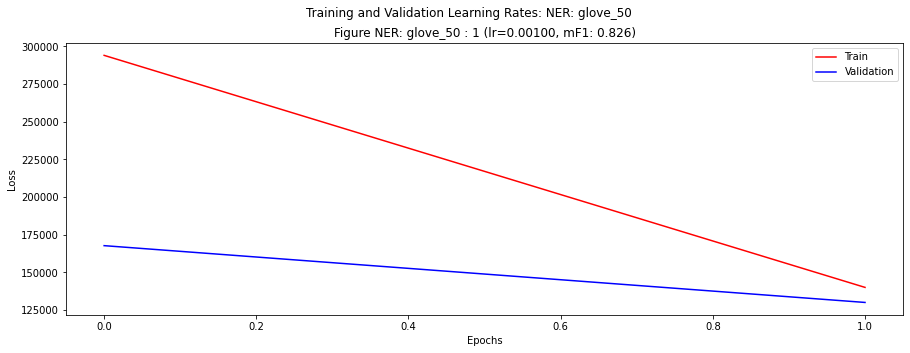

In [4]:
facade.epochs = 2
run(facade)

## Tune hyperparameters

Set model parameters to get a feel for where they need to be before changing features.

2021-05-05 05:48:12,953 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-05 05:48:12,954 [zensols.deeplearn.model.facade] training...
2021-05-05 05:48:12,956 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 2
2021-05-05 05:48:12,956 [zensols.deeplearn.model.executor.status] train/test sets: 110 26
2021-05-05 05:48:12,987 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-05-05 05:48:13,015 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on cuda:0 for 20 epochs using learning rate 0.01
  0%|                                                                                            | 0/20 [00:00<?, ?it/s]2021-05-05 05:48:13,018 [zensols.deeplearn.model.executor.status] watching update file ../target/update.json
tr:6916.542|va min:17073.003|va:18378.148|lr:0.01 /\: 100%|█████████

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 05/05/2021 05:48:13:018554
    ended: 05/05/2021 05:52:14:152448
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 20/20
    ave/min loss: 6916.54239/2138.38214
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 11/20
    ave/min loss: 17073.00315/2292.32929
    accuracy: 0.976 (50092/51348)
    micro: F1: 0.976, precision: 0.976, recall: 0.976
    macro: F1: 0.865, precision: 0.886, recall: 0.847
    weighted: F1: 0.975, precision: 0.975, recall: 0.976
  test:
    started: 05/05/2021 05:52:14:393784
    ended: 05/05/2021 05:52:15:417921
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    ave/min loss:

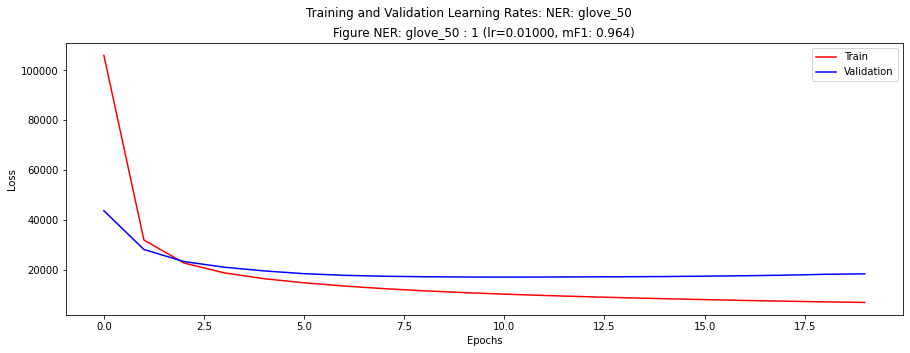

In [5]:
facade.learning_rate = 0.01
facade.epochs = 20
run(facade)

2021-05-05 05:52:15,808 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.300/vec
2021-05-05 05:52:16,454 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-05-05 05:52:16,836 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-05-05 05:52:16,836 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-05-05 05:52:16,996 [zensols.deeplearn.model.facade] clearing
2021-05-05 05:52:17,022 [zensols.deeplearn.model.facade] creating new executor
2021-05-05 05:52:17,028 [zensols.deepnlp.embed.domain] reusing already cached from use cuda: True, device: cuda:0
2021-05-05 05:52:17,038 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-05 05:52:17,039 [zensols.deeplearn.model.facade] training...
2021-05-05 05:52:17,065 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-05-05 05:52:17,066 [zensols.deeplearn.mod

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 05/05/2021 05:52:21:214359
    ended: 05/05/2021 05:54:03:911375
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 8/8
    ave/min loss: 6600.16136/2265.63121
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 6/8
    ave/min loss: 17524.93194/3112.27490
    accuracy: 0.978 (50211/51348)
    micro: F1: 0.978, precision: 0.978, recall: 0.978
    macro: F1: 0.882, precision: 0.912, recall: 0.857
    weighted: F1: 0.977, precision: 0.977, recall: 0.978
  test:
    started: 05/05/2021 05:54:05:298837
    ended: 05/05/2021 05:54:06:465460
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    ave/min loss: 0.0

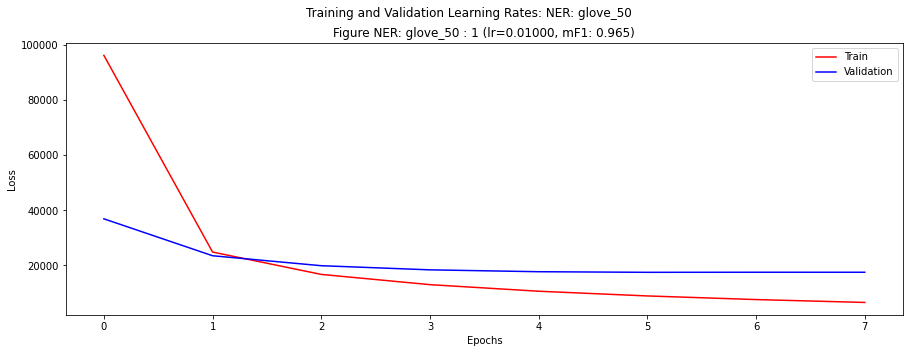

In [6]:
facade.epochs = 8
facade.embedding = 'glove_300_embedding'
run(facade)

2021-05-05 05:54:06,850 [zensols.deepnlp.embed.word2vec] reading binary vector file
2021-05-05 05:54:06,851 [zensols.deepnlp.embed.word2vec] loading keyed file: ../corpus/word2vec/GoogleNews-vectors-negative300.bin
2021-05-05 05:55:00,547 [zensols.deepnlp.embed.word2vec] loaded key model from /home/landes/view/nlp/deepnlp/example/ner/notebook/../corpus/word2vec/GoogleNews-vectors-negative300.bin in 53s
2021-05-05 05:55:00,549 [zensols.deepnlp.embed.word2vec] loaded word2vec model in 53s
2021-05-05 05:55:11,729 [zensols.deepnlp.embed.word2vec] created data structures in 11s
2021-05-05 05:55:12,957 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-05-05 05:55:14,159 [zensols.deeplearn.model.facade] clearing
2021-05-05 05:55:14,177 [zensols.deeplearn.model.facade] creating new executor
2021-05-05 05:55:14,183 [zensols.deepnlp.embed.domain] reusing already cached from use cuda: True, device: cuda:0
2021-05-05 05:55:14,193 [zensols.deeplearn

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 05/05/2021 05:55:21:707674
    ended: 05/05/2021 05:57:55:971566
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 12/12
    ave/min loss: 4669.43406/1395.52244
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 9/12
    ave/min loss: 14605.41574/2148.04376
    accuracy: 0.980 (50304/51348)
    micro: F1: 0.980, precision: 0.980, recall: 0.980
    macro: F1: 0.887, precision: 0.896, recall: 0.879
    weighted: F1: 0.980, precision: 0.980, recall: 0.980
  test:
    started: 05/05/2021 05:58:01:464730
    ended: 05/05/2021 05:58:02:618721
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    ave/min loss: 

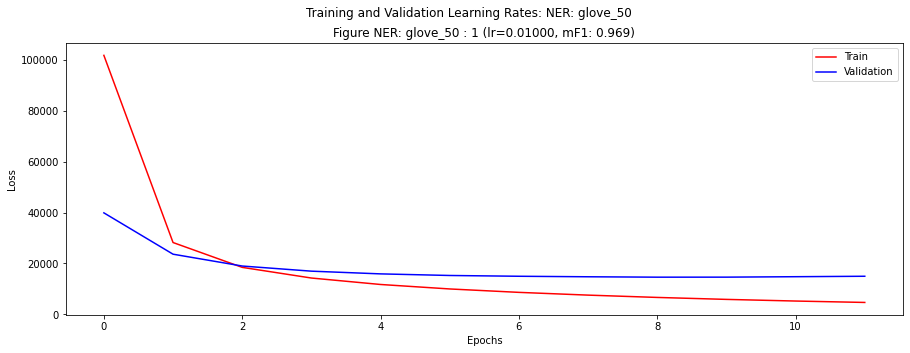

In [7]:
facade.epochs = 12
facade.embedding = 'word2vec_300_embedding'
run(facade)

2021-05-05 05:58:06,724 [zensols.deeplearn.model.facade] clearing
2021-05-05 05:58:06,740 [zensols.deeplearn.model.facade] creating new executor
2021-05-05 05:58:06,828 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-05 05:58:06,829 [zensols.deeplearn.model.facade] training...
2021-05-05 05:58:06,856 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-05-05 05:58:06,856 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-05-05 05:58:15,061 [zensols.deeplearn.model.executor.status] loaded 136 batches in 8s
2021-05-05 05:58:15,061 [zensols.deeplearn.model.executor.status] train/test sets: 110 26
2021-05-05 05:58:15,065 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-05-05 05:58:15,067 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on c

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 05/05/2021 05:58:15:070969
    ended: 05/05/2021 06:03:15:452191
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 10/10
    ave/min loss: 18275.70442/4983.04136
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 10/10
    ave/min loss: 35005.55708/4932.42420
    accuracy: 0.950 (48767/51348)
    micro: F1: 0.950, precision: 0.950, recall: 0.950
    macro: F1: 0.746, precision: 0.765, recall: 0.733
    weighted: F1: 0.949, precision: 0.948, recall: 0.950
  test:
    started: 05/05/2021 06:03:17:266000
    ended: 05/05/2021 06:03:21:386269
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    ave/min loss

zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF (2)

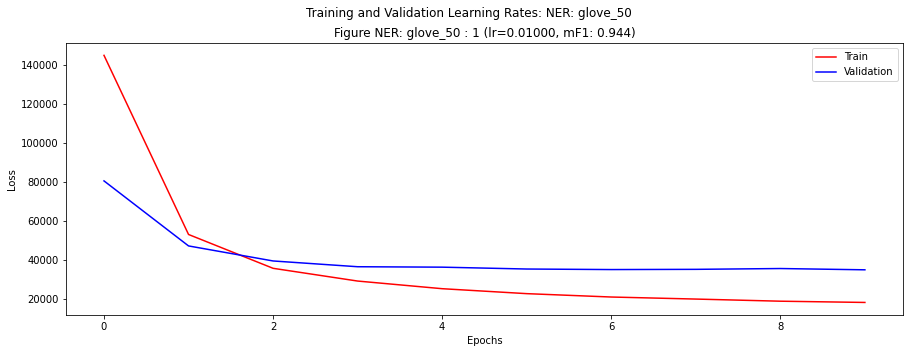

In [8]:
facade.epochs = 10
facade.embedding = 'transformer_fixed_embedding'
facade.net_settings.add_attributes = ()
facade.train()
facade.test()
facade.write_result()
facade.plot_result()

2021-05-05 06:03:21,800 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-05 06:03:21,801 [zensols.deeplearn.model.facade] training...
2021-05-05 06:03:21,802 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 2
2021-05-05 06:03:21,802 [zensols.deeplearn.model.executor.status] train/test sets: 110 26
2021-05-05 06:03:21,807 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-05-05 06:03:21,809 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on cuda:0 for 10 epochs using learning rate 0.01
  0%|                                                   | 0/10 [00:00<?, ?it/s]2021-05-05 06:03:21,811 [zensols.deeplearn.model.executor.status] watching update file ../target/update.json
tr:22014.441|va min:37670.152|va:38572.495|lr:0.01 /\: 100%|█| 10/10 [05:03<00:2021-05-05 06:08:25,695 [zenso

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 05/05/2021 06:03:21:811818
    ended: 05/05/2021 06:08:25:696601
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 10/10
    ave/min loss: 22014.44135/7482.97582
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 9/10
    ave/min loss: 37670.15225/5617.71581
    accuracy: 0.944 (48475/51348)
    micro: F1: 0.944, precision: 0.944, recall: 0.944
    macro: F1: 0.723, precision: 0.739, recall: 0.711
    weighted: F1: 0.942, precision: 0.941, recall: 0.944
  test:
    started: 05/05/2021 06:08:25:811348
    ended: 05/05/2021 06:08:29:828848
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    ave/min loss:

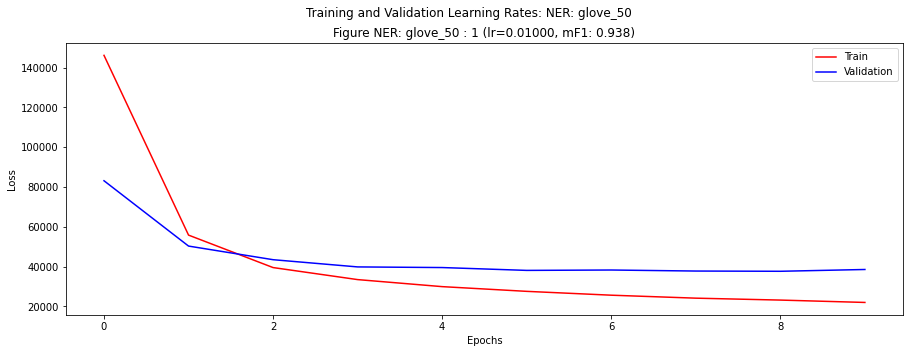

In [9]:
facade.net_settings.add_attributes = ('syns_expander', 'tags_expander')
run(facade)

2021-05-05 06:08:30,214 [notebook] deallocating old facade...
2021-05-05 06:08:30,335 [zensols.deeplearn.model.facade] creating new executor
2021-05-05 06:08:30,382 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-05 06:08:30,383 [zensols.deeplearn.model.facade] training...
2021-05-05 06:08:30,408 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-05-05 06:08:30,408 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-05-05 06:10:11,644 [zensols.deeplearn.model.executor.status] loaded 136 batches in 1 minute, 41s
2021-05-05 06:10:11,645 [zensols.deeplearn.model.executor.status] train/test sets: 110 26
2021-05-05 06:10:11,649 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-05-05 06:10:11,651 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF

Name: NER: transformer_fixed : 1
Run index: 2
Learning rate: 0.001
  train:
    started: 05/05/2021 06:10:11:654272
    ended: 05/05/2021 06:30:31:224156
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 40/40
    ave/min loss: 29016.95044/9313.87719
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 25/40
    ave/min loss: 72939.88915/11854.36280
    accuracy: 0.872 (44795/51348)
    micro: F1: 0.872, precision: 0.872, recall: 0.872
    macro: F1: 0.536, precision: 0.597, recall: 0.497
    weighted: F1: 0.866, precision: 0.863, recall: 0.872
  test:
    started: 05/05/2021 06:30:51:256270
    ended: 05/05/2021 06:30:55:314144
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
    a

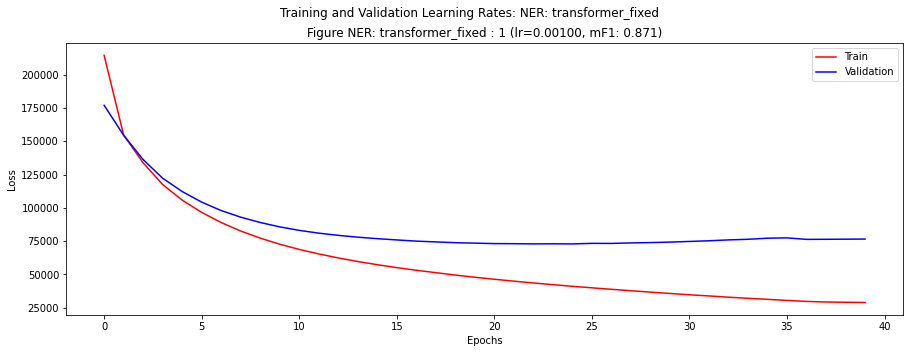

In [10]:
facade = create_facade('transformer-fixed')
run(facade)

2021-05-04 20:04:57,899 [notebook] deallocating old facade...
2021-05-04 20:04:58,006 [zensols.deeplearn.model.facade] creating new executor
2021-05-04 20:04:58,075 [zensols.deeplearn.model.executor.status] resetting executor
2021-05-04 20:04:58,075 [zensols.deeplearn.model.facade] training...
2021-05-04 20:04:58,101 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-05-04 20:04:58,101 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-05-04 20:05:00,381 [zensols.deeplearn.model.executor.status] loaded 136 batches in 2s
2021-05-04 20:05:00,382 [zensols.deeplearn.model.executor.status] train/test sets: 110 26
2021-05-04 20:05:00,541 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-05-04 20:05:00,701 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on cuda:

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 0.001
  train:
    started: 05/04/2021 20:05:00:706332
    ended: 05/05/2021 04:57:45:774394
    batches: 110
    ave data points per batch/total: 127.6/14041
    converged/epochs: 40/40
    ave/min loss: 43169.55837/13914.61258
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 26
    ave data points per batch/total: 125.0/3250
    converged/epochs: 40/40
    ave/min loss: 61550.50499/9857.57348
    accuracy: 0.881 (45217/51348)
    micro: F1: 0.881, precision: 0.881, recall: 0.881
    macro: F1: 0.577, precision: 0.622, recall: 0.547
    weighted: F1: 0.876, precision: 0.874, recall: 0.881
  test:
    started: 05/05/2021 04:57:47:752951
    ended: 05/05/2021 04:59:59:538645
    batches: 27
    ave data points per batch/total: 127.9/3453
    converged/epochs: 1/1
 

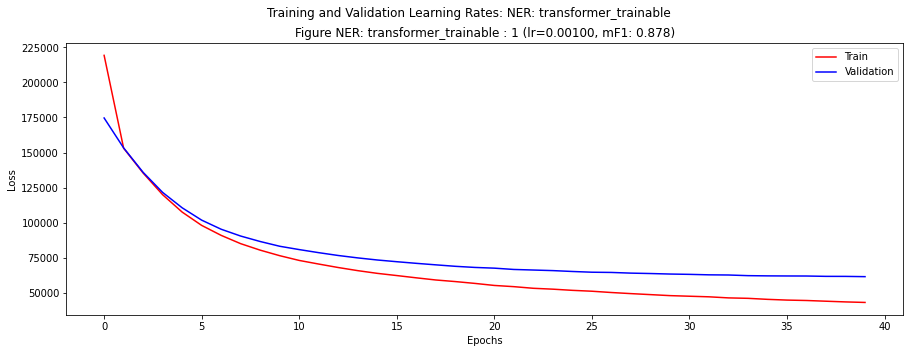

In [11]:
facade = create_facade('transformer-trainable')
run(facade)